# Imports

In [174]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [175]:
np.random.seed(31071967)

# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [176]:
# sanity check
project_config["TKL"]

'AAPL'

# Download TKL data from YF

In [177]:
from datetime import date, timedelta
import yfinance as yf

end_date = date.today() - timedelta(days=1)
start_date = end_date - timedelta(days=int(project_config["HISTORY_DEPTH"])) # 'HISTORY_DEPTH' needs to be defined in project_config

ts = yf.download(project_config["TKL"], start=start_date, end=end_date, auto_adjust=False)

ts = ts.reset_index()[['Date', 'Close']]
ts.columns = ['Date', 'Close']

display(ts.head(1)), display(ts.tail(1))

[*********************100%***********************]  1 of 1 completed


,Date,Close
0,2006-10-06,2.650714


,Date,Close
4820,2025-12-04,280.700012


(None, None)

# Turn time series into supprvied learning table

In [178]:
lags = [1,5,10,22,65] # lookback days
windows =  [5,10,22,65] # statistics windows

df = pd.DataFrame({'Date':ts['Date'],'y':ts["Close"]})

for lag in lags:
  df[f"lag_{lag}"] = df["y"].shift(lag)

for window in windows:
  df[f"min_{window}"] = df["y"].rolling(window=window).min()
  df[f"max_{window}"] = df["y"].rolling(window=window).max()
  df[f"mean_{window}"] = df["y"].rolling(window=window).mean()
  df[f"std_{window}"]  = df["y"].rolling(window=window).std()
  df[f"diff_{window}"] = df["y"].diff(window)
  df[f"pct_change_{window}"] = df["y"].pct_change(window)

df['y_next'] = df['y'].shift(-1)    # tomorrow's price
df.tail(1)['y_next'] = -1               # the target cell

df.dropna(inplace=True)

X = df.drop(['Date','y','y_next'], axis=1)
y = df['y_next']

X.shape, y.shape

((4755, 29), (4755,))

In [179]:
X_train, X_test = X.iloc[:-2], X.iloc[-1:]
y_train, y_test = y.iloc[:-2], y.iloc[-1:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4753, 29), (1, 29), (4753,), (1,))

# Train, Predict, Evaluate

In [180]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror")

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [181]:
pred = xgb.predict(X_test)
mae = mean_absolute_error(y_test, pred)
print("MAE:", mae)

MAE: 2.248199462890625


In [182]:
last_row = X.tail(1)
tomorrow_prediction = xgb.predict(last_row)[0]
tomorrow_prediction

np.float32(278.4518)

<Figure size 1000x600 with 0 Axes>

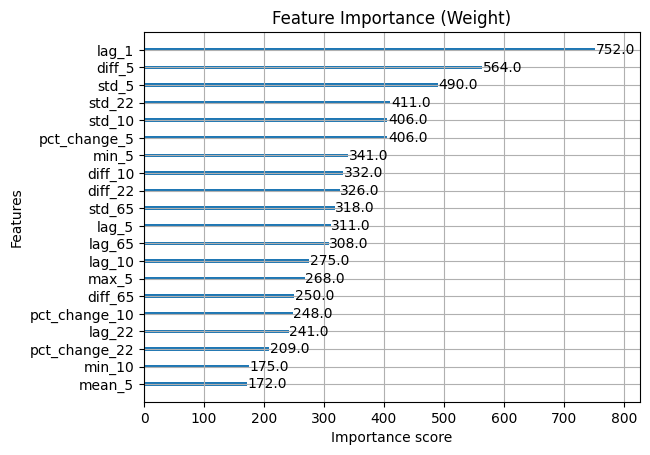

['lag_1', 'diff_5', 'std_5', 'std_22', 'pct_change_5']


In [183]:
import matplotlib.pyplot as plt
import xgboost # Import the xgboost module

# Plot feature importance based on "weight" (number of times a feature appears in a tree)
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Weight)")
plt.show()

# Get the feature importance dictionary
# importance_type can be 'weight', 'gain', or 'cover'
importance_dict = xgb.get_booster().get_score(importance_type='weight')

# 2. Convert to a Pandas DataFrame for easy sorting and viewing
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort by Score (High to Low)
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Extract just the names into a Python list (for use in code)
top_weight_features_list = df_importance['Feature'].head(5).tolist()
print(top_weight_features_list)

In [184]:
top_weight_features = ['lag_1','diff_5','std_5','skew_5','diff_10','mean_5','pct_change_5','kurt_10','skew_10','kurt_5','std_10','std_22','lag2']

<Figure size 1000x600 with 0 Axes>

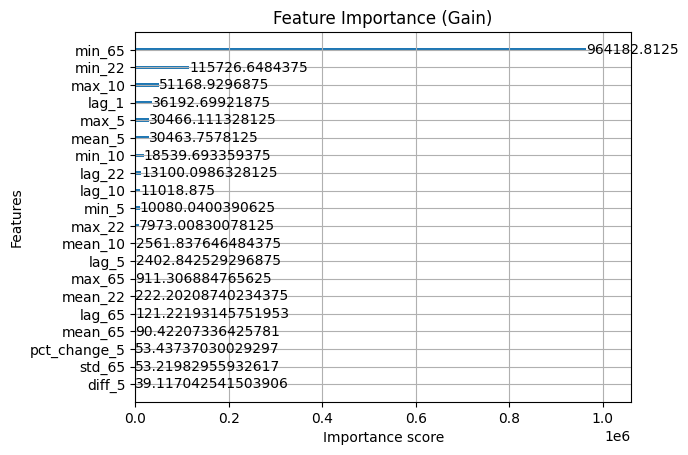

['min_65', 'min_22', 'max_10', 'lag_1', 'max_5']


In [185]:
# OPTIONAL: Plot based on "gain" (average gain of splits which use the feature)
# "Gain" is often more accurate for finding what actually drives the prediction.
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, importance_type='gain', max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Gain)")
plt.show()

# Get the feature importance dictionary
# importance_type can be 'weight', 'gain', or 'cover'
importance_dict = xgb.get_booster().get_score(importance_type='gain')

# 2. Convert to a Pandas DataFrame for easy sorting and viewing
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort by Score (High to Low)
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Extract just the names into a Python list (for use in code)
top_gain_features_list = df_importance['Feature'].head(5).tolist()
print(top_gain_features_list)

In [186]:
top_features = list(set(top_gain_features_list) | set(top_weight_features_list))
final_df = df[ ['Date','y']+top_features ]

In [187]:
final_df

,Date,y,lag_1,std_22,pct_change_5,diff_5,max_10,max_5,std_5,min_22,min_65
65,2007-01-11,3.421429,3.464286,0.152898,0.118375,0.362143,3.464286,3.464286,0.201501,2.888214,2.615357
66,2007-01-12,3.379286,3.421429,0.164440,0.112522,0.341786,3.464286,3.464286,0.162988,2.888214,2.615357
67,2007-01-16,3.467857,3.379286,0.181704,0.136071,0.415357,3.467857,3.467857,0.067352,2.888214,2.615357
68,2007-01-17,3.391071,3.467857,0.190676,0.025710,0.085000,3.467857,3.467857,0.040723,2.888214,2.653214
69,2007-01-18,3.181071,3.391071,0.190685,-0.081753,-0.283215,3.467857,3.467857,0.110032,2.888214,2.653214
...,...,...,...,...,...,...,...,...,...,...,...
4815,2025-11-26,277.549988,276.970001,3.152479,0.033475,8.989990,277.549988,277.549988,4.764712,266.250000,226.789993
4816,2025-11-28,278.850006,277.549988,3.524993,0.047324,12.600006,278.850006,278.850006,2.814729,266.250000,226.789993
4817,2025-12-01,283.100006,278.850006,4.277118,0.042764,11.610016,283.100006,283.100006,2.791948,266.250000,226.789993
4818,2025-12-02,286.190002,283.100006,5.219357,0.037221,10.269989,286.190002,286.190002,3.969162,266.250000,226.789993


In [196]:
df_pickle_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.df.pkl"
df_csv_path = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"
final_df.to_pickle(df_pickle_path)
final_df.to_csv(df_csv_path)